<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/Copy_of_second_cough_model(augmentation)(coswara%2Bcoughvid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

---
# 1-Prepare Data
---



## Download Data

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 775, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 775 (delta 1), reused 12 (delta 1), pack-reused 762
Receiving objects: 100% (775/775), 14.63 GiB | 40.16 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Checking out files: 100% (186/186), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20200525
20210930
20200604
20210618
20200505
20210603
20210816
20210426
20200803
20200419
20201012
20200415
20200911
20201221
20200502
20210630
20200901
20201130
20200424
20210406
20210914
20200720
20200430
20200504
20210830
20210206
20210523
20200707
20220116
20210419
20200824
20200930
20200919
20200413
20200418
20200416
20210507
20200417
20201031
20210714
20200820
20200814


In [ ]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-02-24 17:01:53--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  20.9MB/s    in 40s     

2022-02-24 17:02:34 (22.8 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head() #includes +ve and -ve 

100%|██████████| 2373/2373 [00:37<00:00, 62.70it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,AwzhLro3l6Wa5kPJyzyB6BNgVqN2,resp_illness_not_identified,/content/Coswara-Data/20200525/AwzhLro3l6Wa5kP...,0,0,coswara
0,zOmz0TaNdmQfF2jUFkqUKuNa80m1,healthy,/content/Coswara-Data/20200525/zOmz0TaNdmQfF2j...,0,0,coswara
0,fja76ZsTgfPWoDCUcwnRLI5XrLZ2,healthy,/content/Coswara-Data/20200525/fja76ZsTgfPWoDC...,0,1,coswara
0,tZ4S3CC8pvNc72VYadUYndOUlCE3,healthy,/content/Coswara-Data/20200525/tZ4S3CC8pvNc72V...,0,0,coswara
0,6wlO9IzJRZZ3tp02z0La8JCAU8Z2,healthy,/content/Coswara-Data/20200525/6wlO9IzJRZZ3tp0...,0,0,coswara


In [ ]:
positive_mild = CosData1.loc[CosData1['STATUS']=='positive_mild']
positive_moderate	 = CosData1.loc[CosData1['STATUS']=='positive_moderate']
positive_asymp = CosData1.loc[CosData1['STATUS']=='positive_asymp']

positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData1.loc[CosData1['STATUS']=='healthy']
resp_illness_not_identified = CosData1.loc[CosData1['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData1.loc[CosData1['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData1.loc[CosData1['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(positive))
print(len(negative))

f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:1200]
print(len(f_negative))




522
1851
1200


In [ ]:
positive

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,jQDuUZiOBuOuEfF28lMPmnCV0OO2,positive_mild,/content/Coswara-Data/20210930/jQDuUZiOBuOuEfF...,1,1,coswara
0,XpMEOhbTdsSYUjo2zsmVjnVOsoK2,positive_mild,/content/Coswara-Data/20210930/XpMEOhbTdsSYUjo...,1,0,coswara
0,2tjg2NfgJPaYdgTZRDUBhWm8F133,positive_mild,/content/Coswara-Data/20210930/2tjg2NfgJPaYdgT...,0,1,coswara
0,UKrkCs1fdsVnZ7EfqWJCRxvIyZ22,positive_mild,/content/Coswara-Data/20210930/UKrkCs1fdsVnZ7E...,0,1,coswara
0,rAWA4P9I7iYPCIvEheITe8FCRKP2,positive_mild,/content/Coswara-Data/20210930/rAWA4P9I7iYPCIv...,1,1,coswara
...,...,...,...,...,...,...
0,kBFDtvAVY9QYbi7YHYgd7tNpsWx1,positive_asymp,/content/Coswara-Data/20200820/kBFDtvAVY9QYbi7...,0,0,coswara
0,Fx2gbIoPlJXrK5OD8FMeepOGlLa2,positive_asymp,/content/Coswara-Data/20200820/Fx2gbIoPlJXrK5O...,0,0,coswara
0,40NRJEGpU9Vg2IFXcuqCQLiKLVz1,positive_asymp,/content/Coswara-Data/20200820/40NRJEGpU9Vg2IF...,0,0,coswara
0,TaoyZAahOzRoDQRxb0DtDZh8Opa2,positive_asymp,/content/Coswara-Data/20200820/TaoyZAahOzRoDQR...,0,0,coswara


In [ ]:
'''
CosData   = pd.concat([positive,f_negative])
CosData   = CosData.sample(frac=1)

CosData.head()

SyntaxError: ignored

## Prepare dataset

In [ ]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19']

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
## TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,52de6b02-84b4-4e74-9061-983488b4e300,0,0,COVID-19,/content/public_dataset/52de6b02-84b4-4e74-906...,coughvid
1,6fd8a8a8-cc36-4823-b2b0-39a37673baf9,0,0,healthy,/content/public_dataset/6fd8a8a8-cc36-4823-b2b...,coughvid
2,e5d64958-a006-4d44-b687-edc4f14cbe24,0,1,healthy,/content/public_dataset/e5d64958-a006-4d44-b68...,coughvid
3,bbd4ca87-d3b0-44cf-ba86-bd92565c1a27,0,1,healthy,/content/public_dataset/bbd4ca87-d3b0-44cf-ba8...,coughvid
4,276b80cf-2966-4d70-ae9c-0139189155db,0,0,healthy,/content/public_dataset/276b80cf-2966-4d70-ae9...,coughvid


In [ ]:
TotData2 = TotData["STATUS"].unique()
print(TotData2)

['COVID-19' 'healthy' 'symptomatic']


In [ ]:
 ds=TotData["DataSet"].unique()
 print(ds)

['coughvid']


In [ ]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
#symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ][:490]
healthy_TotData = TotData[TotData["STATUS"] != "COVID-19" ][:975]

print(len(covid_TotData) , len(healthy_TotData))
covid_TotData.head()




441 975


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,52de6b02-84b4-4e74-9061-983488b4e300,0,0,COVID-19,/content/public_dataset/52de6b02-84b4-4e74-906...,coughvid
15,e1259ecf-0b60-4106-9852-61c945065ab1,0,0,COVID-19,/content/public_dataset/e1259ecf-0b60-4106-985...,coughvid
22,e58d45f3-7d6e-48e6-801b-eafc15f1ec85,1,1,COVID-19,/content/public_dataset/e58d45f3-7d6e-48e6-801...,coughvid
35,240021ec-048e-431d-9548-11d7c234389e,1,1,COVID-19,/content/public_dataset/240021ec-048e-431d-954...,coughvid
65,6d194cdc-ba5a-40ba-8232-5bf150026c67,0,1,COVID-19,/content/public_dataset/6d194cdc-ba5a-40ba-823...,coughvid


In [ ]:
'''
TotData_con = pd.concat([covid_TotData,symptomatic_TotData,healthy_TotData])
print(len(TotData_con))

# Data Augmentaion

In [ ]:
#!pip install audiomentations
!pip install audiomentations


     |████████████████████████████████| 60 kB 3.6 MB/s 


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa
print(len(covid_TotData))
print(len(positive))

441
522


In [ ]:
'''
print(positive['ID'][:1])
for audio_file in  tqdm(positive["DIR"][:10]):
  print(audio_file.split('/')[-2])

#  /content/Coswara-Data/20201012/L9QbDvX4UtMhFOsYuh2aamY3VK23/cough-shallow.wav
#                                 L9QbDvX4UtMhFOsYuh2aamY3VK23
#                                 L9QbDvX4UtMhFOsYuh2aamY3VK23

In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

os.makedirs("augmented_data_coswara")

xx = pd.DataFrame()


##Augmented coswara

In [ ]:


#os.makedirs("augmented_data_coswara")

xx = pd.DataFrame()

for audio_file in  tqdm(positive["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav", augmented_sample, sr) #write with wav extantion

    xx = xx.append(positive.loc[positive['ID'] == audio_file.split("/")[-2]])
    xx["DIR"].replace({ audio_file : "/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav"}, inplace=True)
    xx["ID"].replace({ audio_file.split("/")[-2] :  audio_file.split("/")[-2] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

 21%|██▏       | 111/522 [00:44<02:08,  3.20it/s]


 File Not Found :))


100%|██████████| 522/522 [03:17<00:00,  2.64it/s]


In [ ]:
print(len(xx))
xx.head()

521


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,6T43bddKoKfG7MwnJWvrPZSsyrc2AUG,positive_mild,/content/augmented_data_coswara/6T43bddKoKfG7M...,1,1,coswara
0,FLNZB0Us1PgOdXLJUC4tmsvRrH43AUG,positive_mild,/content/augmented_data_coswara/FLNZB0Us1PgOdX...,0,1,coswara
0,IjI3eQUHkrYdJSB4nWeXeNoryNl2AUG,positive_mild,/content/augmented_data_coswara/IjI3eQUHkrYdJS...,0,0,coswara
0,CGXh77ubexNuv0UUmOHVCnAgurY2AUG,positive_mild,/content/augmented_data_coswara/CGXh77ubexNuv0...,1,1,coswara
0,lN052zCWrOOH1v9C4wYibgJDZA62AUG,positive_mild,/content/augmented_data_coswara/lN052zCWrOOH1v...,0,1,coswara


In [ ]:

os.makedirs("augmented_data_coughvid")

yy = pd.DataFrame()

for audio_file in  tqdm(covid_TotData["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion

    yy = yy.append(covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]])
    yy["DIR"].replace({"/content/augmented_data_coughvid/"+ audio_file.split("/")[-1][0:-5] + ".webm": "/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav"}, inplace=True)
    yy["ID"].replace({ audio_file.split("/")[-1][0:-5] :  audio_file.split("/")[-1][0:-5] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

  0%|          | 0/441 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/441 [00:01<10:57,  1.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/441 [00:02<08:12,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/441 [00:03<06:53,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/441 [00:03<06:30,  1.12it/s]/usr/local/li


 File Not Found :))


 11%|█▏        | 50/441 [00:40<05:21,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 51/441 [00:41<05:10,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 52/441 [00:41<05:14,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 53/441 [00:42<05:03,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 54/441 [00:43<05:00,  1.29it/s]


 File Not Found :))


 15%|█▌        | 68/441 [00:54<04:23,  1.42it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 69/441 [00:55<04:33,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 70/441 [00:56<05:22,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 71/441 [00:57<05:46,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 72/441 [00:58<05:23,  1.14it/s]


 File Not Found :))


 33%|███▎      | 144/441 [02:16<04:01,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 145/441 [02:17<04:03,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 146/441 [02:18<04:16,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 147/441 [02:19<04:11,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 148/441 [02:20<04:01,  1.21


 File Not Found :))


 40%|████      | 178/441 [02:48<03:19,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 179/441 [02:49<03:45,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 180/441 [02:50<03:34,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 181/441 [02:50<03:01,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████▏     | 182/441 [02:51<03:28,  1.24


 File Not Found :))


 51%|█████     | 224/441 [03:26<02:34,  1.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 225/441 [03:26<02:33,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 226/441 [03:27<02:40,  1.34it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 227/441 [03:28<03:01,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 228/441 [03:29<02:36,  1.36


 File Not Found :))


 95%|█████████▌| 419/441 [06:16<00:13,  1.58it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▌| 420/441 [06:16<00:13,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▌| 421/441 [06:17<00:12,  1.59it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 422/441 [06:18<00:15,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 423/441 [06:19<00:15,  1.18


 File Not Found :))


 98%|█████████▊| 433/441 [06:27<00:04,  1.61it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 434/441 [06:27<00:03,  1.77it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▊| 435/441 [06:28<00:03,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 436/441 [06:29<00:03,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 437/441 [06:30<00:02,  1.36

In [ ]:

print(len(yy))
yy.head()

434


,ID,Fever/MP,ORC,STATUS,DIR,DataSet
14,bdd15ab3-7347-4a29-b5f2-6a63f70bfe6aAUG,0,0,COVID-19,/content/public_dataset/bdd15ab3-7347-4a29-b5f...,coughvid
15,bac8326b-2652-443d-8b58-af96cdf5284dAUG,1,0,COVID-19,/content/public_dataset/bac8326b-2652-443d-8b5...,coughvid
19,6d941efe-43f9-4a64-8172-58cbb20400abAUG,1,1,COVID-19,/content/public_dataset/6d941efe-43f9-4a64-817...,coughvid
57,88024607-e701-4a54-adeb-c4c1ecc282f4AUG,1,0,COVID-19,/content/public_dataset/88024607-e701-4a54-ade...,coughvid
87,d0a4cbf7-263d-49f1-978d-8cf767546e3cAUG,1,0,COVID-19,/content/public_dataset/d0a4cbf7-263d-49f1-978...,coughvid


In [ ]:
'''
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

os.makedirs("augmented_data")
idx=0;
last_id = 6088
for audio_file in tqdm(covid_TotData["DIR"]):
  try:
    last_id+=1
    samples, sr = librosa.load(audio_file) #get audio file from dataset
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion
    if idx ==0: 
      aug_positive_samples = covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]] # initalize new table aug_positive_samples
      aug_positive_samples["DIR"] = "/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav"
      aug_positive_samples["ID"] = last_id

    else:
      aug_positive_samples = aug_positive_samples.append(covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]],ignore_index=True)
      aug_positive_samples["DIR"] = "/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav"
      aug_positive_samples["ID"] = last_id
    idx=idx + 1
  except:
    print("\n File Not Found :))")

In [ ]:
#pip install pandas

In [ ]:
#import pandas as pd

In [ ]:
#aug_positive_samples.head()

In [ ]:
#print(aug_positive_samples["DIR"][0])
#frames =[covid_TotData,aug_positive_samples]
#covid_TotData = pd.concat(frames)


In [ ]:
#print(len(aug_positive_samples))
#test_test = aug_positive_samples[:10]

#spilt to train - test - validation


In [ ]:

covid_TotData_train = covid_TotData[:308]    # split 70, 15, 15
covid_TotData_val = covid_TotData[308:374]     #covid_TotData = 441 ... 308,66,67
covid_TotData_test = covid_TotData[374:]


healthy_TotData_train = healthy_TotData[:682]   #covid_TotData = 975 ... 682,147,146
healthy_TotData_val = healthy_TotData[682:829]
healthy_TotData_test = healthy_TotData[829:]

aug_covid_samples_train = yy[:303]   #yy = 434
aug_covid_samples_val = yy[303:369]
aug_covid_samples_test = yy[369:]



aug_positive_samples_train = xx[:365]   #xx = 521
aug_positive_samples_val = xx[365:443]
aug_positive_samples_test = xx[443:]



positive_samples_train = positive[:365]    #positive = 522
positive_samples_val = positive[365:443]
positive_samples_test = positive[443:]


negative_samples_train = f_negative[:840]    #f_negative = 1200
negative_samples_val = f_negative[840:1020]
negattive_samples_test = f_negative[1020:]




In [ ]:
print(len(covid_TotData_train),len(healthy_TotData_train),len(aug_covid_samples_train),len(aug_positive_samples_train),len(positive_samples_train),len(negative_samples_train))
print(len(covid_TotData_val),  len(healthy_TotData_val),  len(aug_covid_samples_val),  len(aug_positive_samples_val),  len(positive_samples_val),  len(negative_samples_val))
print(len(covid_TotData_test), len(healthy_TotData_test), len(aug_covid_samples_test), len(aug_positive_samples_test), len(positive_samples_test), len(negattive_samples_test))

308 682 303 365 365 840
66 147 66 78 78 180
67 146 65 78 79 180


In [ ]:
#train Data
frame1 = [covid_TotData_train,healthy_TotData_train,aug_covid_samples_train,aug_positive_samples_train,positive_samples_train,negative_samples_train]
Data_train = pd.concat(frame1)


# validation Data
frame2 = [covid_TotData_val,healthy_TotData_val,aug_covid_samples_val,aug_positive_samples_val,positive_samples_val,negative_samples_val
]
Data_val = pd.concat(frame2)

# test Data
frame3 = [covid_TotData_test,healthy_TotData_test,aug_covid_samples_test,aug_positive_samples_test,positive_samples_test,negattive_samples_test]
Data_test = pd.concat(frame3)
print(len(Data_train) , len(Data_val) , len(Data_test))

2863 615 615


In [ ]:
Data_train.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
14,bdd15ab3-7347-4a29-b5f2-6a63f70bfe6a,0,0,COVID-19,/content/public_dataset/bdd15ab3-7347-4a29-b5f...,coughvid
15,bac8326b-2652-443d-8b58-af96cdf5284d,1,0,COVID-19,/content/public_dataset/bac8326b-2652-443d-8b5...,coughvid
19,6d941efe-43f9-4a64-8172-58cbb20400ab,1,1,COVID-19,/content/public_dataset/6d941efe-43f9-4a64-817...,coughvid
57,88024607-e701-4a54-adeb-c4c1ecc282f4,1,0,COVID-19,/content/public_dataset/88024607-e701-4a54-ade...,coughvid
87,d0a4cbf7-263d-49f1-978d-8cf767546e3c,1,0,COVID-19,/content/public_dataset/d0a4cbf7-263d-49f1-978...,coughvid


In [ ]:
Data_val.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
4363,25a6fb1b-a42c-4728-a2bf-d0613e17d1d7,1,1,COVID-19,/content/public_dataset/25a6fb1b-a42c-4728-a2b...,coughvid
4372,e56ea219-e97c-45c4-8222-5ecf168445b5,0,0,COVID-19,/content/public_dataset/e56ea219-e97c-45c4-822...,coughvid
4380,76a03d41-09de-4d00-b1e6-0cedf0b3dbda,0,0,COVID-19,/content/public_dataset/76a03d41-09de-4d00-b1e...,coughvid
4382,637d6498-1d52-4860-9976-5a7a94f2a0c3,1,1,COVID-19,/content/public_dataset/637d6498-1d52-4860-997...,coughvid
4395,9aea1b03-9fc0-48c9-9e62-a6ac15633c03,0,0,COVID-19,/content/public_dataset/9aea1b03-9fc0-48c9-9e6...,coughvid


In [ ]:
Data_test.head()

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
5232,b3add103-8854-4aba-8448-18361df4dac2,1,0,COVID-19,/content/public_dataset/b3add103-8854-4aba-844...,coughvid
5233,178f39e2-a261-4ec6-a8fb-3f89c3c795bb,0,1,COVID-19,/content/public_dataset/178f39e2-a261-4ec6-a8f...,coughvid
5236,74d33247-658a-45ea-a641-5b736ee5498f,1,0,COVID-19,/content/public_dataset/74d33247-658a-45ea-a64...,coughvid
5247,8ebca537-22d5-45fd-9f1c-60a58622284d,0,1,COVID-19,/content/public_dataset/8ebca537-22d5-45fd-9f1...,coughvid
5254,2018bfea-0071-4aca-8d45-18dac4d65199,0,0,COVID-19,/content/public_dataset/2018bfea-0071-4aca-8d4...,coughvid




```
# This is formatted as code
```

## Feature Extraction

In [ ]:
'''
audio,sr = librosa.load('/content/augmented_data/031fd54a-87b5-4223-9af6-60985127fb7a.wav')
mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=13)
mfccsscaled = np.mean(mfccs.T,axis=0)
pylab.axis('off') # no axis
pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
s_db     = librosa.power_to_db(melspec, ref=np.max)
librosa.display.specshow(s_db)
savepath = os.path.join(custpath,'oo'+'.png')
pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
pylab.close()


In [ ]:
def feature_extractor(row):

  name     = row[-6]
  try:
    audio,sr = librosa.load(row[-2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=22050, n_mfcc=13)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
   # return mfccsscaled

  return mfccsscaled,savepath



In [ ]:
'''
features = []
diagnoses= []
imgpaths = []

for row in tqdm(xx.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[-5],row[-4]])

In [ ]:
'''
isnone = lambda x: x is not None
label  = lambda x: 2 if x == 'COVID-19' else( 1 if x == 'symptomatic' else 0)
cast_x = list(map(isnone,features))
data_y = list(map(label,xx['STATUS']))


data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

In [ ]:
'''
print(len(data_x))

In [ ]:
'''
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 1
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
'''
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

In [ ]:
#train
features_train = []
diagnoses_train= []
imgpaths_train = []
#validation
features_val = []
diagnoses_val= []
imgpaths_val = []
#test
features_test = []
diagnoses_test= []
imgpaths_test = []

In [ ]:
'''
features_test_test = []
diagnoses_test_test= []
imgpaths_test_test = []
#test
i=0
for row in tqdm(aug_positive_samples.values):
  #mfccs,savepath   
  feature_extractor(row)
  i+=1
  features_test_test.append(mfccs)
  #imgpaths_test_test.append(savepath)
  #diagnoses_test_test.append([row[-5],row[-4]])

In [ ]:
'''
print(i)
isnone = lambda x: x is not None
cast_x = list(map(isnone,features_test_test))
data_x = [features_test_test[i] for i in range(len(features_test_test)) if cast_x[i] == True]
print(len(data_x))

In [ ]:
# train
for row in tqdm(Data_train.values):
  mfccs,savepath  = feature_extractor(row)
  features_train.append(mfccs)
  imgpaths_train.append(savepath)
  diagnoses_train.append([row[-5],row[-4]])




  0%|          | 0/2863 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/2863 [00:00<26:14,  1.82it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/2863 [00:01<38:04,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/2863 [00:02<49:53,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/2863 [00:04<1:05:53,  1.38s/it]/usr/l

File cannot open


  2%|▏         | 50/2863 [00:50<41:56,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 51/2863 [00:51<43:08,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 52/2863 [00:52<44:01,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 53/2863 [00:53<44:36,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 54/2863 [00:54<45:04,  1.04

File cannot open


  2%|▏         | 68/2863 [01:07<32:42,  1.42it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 69/2863 [01:08<36:35,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 70/2863 [01:09<39:43,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 71/2863 [01:10<41:33,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 72/2863 [01:10<39:13,  1.19

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 144/2863 [02:18<37:05,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 145/2863 [02:19<37:23,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 146/2863 [02:20<39:04,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 147/2863 [02:21<41:28,  1.09it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 178/2863 [02:55<40:29,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 179/2863 [02:56<42:56,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 180/2863 [02:57<44:16,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 181/2863 [02:58<40:15,  1.11it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 224/2863 [03:40<39:04,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 225/2863 [03:41<41:13,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 226/2863 [03:42<43:09,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 227/2863 [03:43<44:29,  1.01s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 372/2863 [06:16<37:13,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 373/2863 [06:17<40:30,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 374/2863 [06:18<37:21,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 375/2863 [06:19<39:32,  1.05it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 410/2863 [06:54<29:36,  1.38it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 411/2863 [06:55<32:41,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 412/2863 [06:56<37:22,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 413/2863 [06:57<37:56,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 414/2863 [06:58<39:32,  1.03it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 416/2863 [06:59<37:06,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 417/2863 [07:01<40:27,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 418/2863 [07:02<42:43,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 419/2863 [07:03<42:02,  1.03s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 427/2863 [07:12<41:06,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 428/2863 [07:13<43:23,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 429/2863 [07:14<44:39,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 430/2863 [07:15<45:47,  1.13s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 432/2863 [07:17<40:15,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 433/2863 [07:18<46:08,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 434/2863 [07:19<44:09,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 435/2863 [07:21<49:37,  1.23s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 479/2863 [08:14<41:22,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 480/2863 [08:15<44:17,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 481/2863 [08:16<41:57,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 482/2863 [08:17<44:33,  1.12s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 535/2863 [09:20<41:18,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 536/2863 [09:21<43:22,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 537/2863 [09:22<45:09,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 538/2863 [09:23<44:44,  1.15s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 673/2863 [12:09<41:35,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 674/2863 [12:10<40:47,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 675/2863 [12:11<33:45,  1.08it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 676/2863 [12:12<38:22,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 677/2863 [12:13<41:34,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 678/2863 [12:15<44:00,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 679/2863 [12:16<45:41,  1.26s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 685/2863 [12:22<38:00,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 686/2863 [12:24<38:56,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 687/2863 [12:25<42:01,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 688/2863 [12:26<44:33,  1.23s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 697/2863 [12:37<40:58,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 698/2863 [12:38<42:08,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 699/2863 [12:39<44:21,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 700/2863 [12:40<41:19,  1.15s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 705/2863 [12:45<31:43,  1.13it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 706/2863 [12:47<37:20,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 707/2863 [12:48<41:06,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 708/2863 [12:49<43:15,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 709/2863 [12:51<42:45,  1.19s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 714/2863 [12:56<37:04,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 715/2863 [12:57<37:20,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 716/2863 [12:58<40:08,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 717/2863 [13:00<42:55,  1.20s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 771/2863 [14:07<37:42,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 772/2863 [14:08<41:11,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 773/2863 [14:10<43:21,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 774/2863 [14:11<44:59,  1.29s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 791/2863 [14:33<41:15,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 792/2863 [14:34<43:34,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 793/2863 [14:35<45:06,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 794/2863 [14:37<45:26,  1.32s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 799/2863 [14:42<38:58,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 800/2863 [14:44<41:57,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 801/2863 [14:45<40:17,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 802/2863 [14:46<40:24,  1.18s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 841/2863 [15:40<40:28,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 842/2863 [15:41<39:04,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 843/2863 [15:42<41:16,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 844/2863 [15:44<43:43,  1.30s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 884/2863 [16:38<39:42,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 885/2863 [16:39<40:11,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 886/2863 [16:40<39:57,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 887/2863 [16:42<42:15,  1.28s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 892/2863 [16:48<37:18,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 893/2863 [16:49<36:35,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 894/2863 [16:50<39:53,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 895/2863 [16:52<42:09,  1.29s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 916/2863 [17:21<40:05,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 917/2863 [17:22<42:25,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 918/2863 [17:23<43:31,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 919/2863 [17:25<44:39,  1.38s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 929/2863 [17:42<45:34,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 930/2863 [17:43<46:06,  1.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 931/2863 [17:45<46:37,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 932/2863 [17:46<47:12,  1.47s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 955/2863 [18:17<40:02,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 956/2863 [18:19<42:34,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 957/2863 [18:20<44:08,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 958/2863 [18:22<45:16,  1.43s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


 71%|███████   | 2039/2863 [32:10<07:02,  1.95it/s]

File cannot open


 74%|███████▍  | 2126/2863 [32:59<06:57,  1.76it/s]

File cannot open


 74%|███████▍  | 2131/2863 [33:03<10:24,  1.17it/s]

File cannot open


 75%|███████▍  | 2144/2863 [33:12<09:06,  1.32it/s]

File cannot open


 76%|███████▋  | 2190/2863 [33:33<04:15,  2.63it/s]

File cannot open


 77%|███████▋  | 2199/2863 [33:37<05:34,  1.99it/s]

File cannot open


 80%|████████  | 2295/2863 [34:26<04:43,  2.01it/s]

File cannot open


 90%|█████████ | 2582/2863 [36:38<02:06,  2.22it/s]

File cannot open


 91%|█████████▏| 2613/2863 [36:52<01:54,  2.18it/s]

File cannot open


 93%|█████████▎| 2659/2863 [37:13<01:53,  1.80it/s]

File cannot open


 94%|█████████▍| 2700/2863 [37:36<01:26,  1.88it/s]

File cannot open


 94%|█████████▍| 2702/2863 [37:36<01:07,  2.38it/s]

File cannot open


 95%|█████████▍| 2713/2863 [37:43<01:21,  1.83it/s]

File cannot open


 96%|█████████▌| 2740/2863 [37:59<01:01,  2.01it/s]

File cannot open


 97%|█████████▋| 2765/2863 [38:11<00:51,  1.90it/s]

File cannot open


 99%|█████████▉| 2836/2863 [38:50<00:13,  2.02it/s]

File cannot open


100%|██████████| 2863/2863 [39:02<00:00,  1.22it/s]


In [ ]:
#validation
for row in tqdm(Data_val.values):
  mfccs,savepath  = feature_extractor(row)
  features_val.append(mfccs)
  imgpaths_val.append(savepath)
  diagnoses_val.append([row[-5],row[-4]])

  0%|          | 0/615 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/615 [00:03<32:15,  3.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/615 [00:05<27:10,  2.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/615 [00:07<25:19,  2.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/615 [00:10<24:39,  2.42s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 101/615 [03:46<17:47,  2.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 102/615 [03:48<17:18,  2.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 103/615 [03:50<17:04,  2.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 104/615 [03:52<17:54,  2.10s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 135/615 [05:00<16:26,  2.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 136/615 [05:03<17:07,  2.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 137/615 [05:05<17:24,  2.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 138/615 [05:07<17:45,  2.23s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 159/615 [05:55<16:12,  2.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 160/615 [05:57<16:42,  2.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 161/615 [06:00<17:04,  2.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▋       | 162/615 [06:02<17:17,  2.29s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


 76%|███████▌  | 466/615 [11:41<01:20,  1.85it/s]

File cannot open


 76%|███████▌  | 468/615 [11:42<00:57,  2.55it/s]

File cannot open


 90%|████████▉ | 552/615 [12:21<00:24,  2.62it/s]

File cannot open


100%|██████████| 615/615 [12:48<00:00,  1.25s/it]


In [ ]:
#test
for row in tqdm(Data_test.values):
  mfccs,savepath  = feature_extractor(row)
  features_test.append(mfccs)
  imgpaths_test.append(savepath)
  diagnoses_test.append([row[-5],row[-4]])

  0%|          | 0/615 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/615 [00:03<38:02,  3.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/615 [00:05<29:04,  2.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/615 [00:08<27:43,  2.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/615 [00:11<27:12,  2.67s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 45/615 [02:08<27:28,  2.89s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 46/615 [02:11<26:21,  2.78s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 47/615 [02:13<24:26,  2.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 48/615 [02:16<24:24,  2.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 59/615 [02:42<20:16,  2.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 60/615 [02:44<20:21,  2.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 61/615 [02:47<21:24,  2.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 62/615 [02:49<22:05,  2.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 78/615 [03:27<17:20,  1.94s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 79/615 [03:29<18:55,  2.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 80/615 [03:32<19:47,  2.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 81/615 [03:34<20:14,  2.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 82/615 [03:37<20:22,  2.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 128/615 [05:31<18:21,  2.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 129/615 [05:33<18:34,  2.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 130/615 [05:36<19:13,  2.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 131/615 [05:38<19:36,  2.43s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 143/615 [06:07<17:46,  2.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 144/615 [06:09<15:50,  2.02s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 145/615 [06:11<17:00,  2.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 146/615 [06:14<17:53,  2.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 147/615 [06:16<17:28,  2.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 148/615 [06:18<17:46,  2.28s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


100%|██████████| 615/615 [14:01<00:00,  1.37s/it]


---
# 2- Data Sampling 
---

## Remove Nans





In [ ]:
isnone = lambda x: x is not None
label_train  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_train = list(map(isnone,features_train))
data_y_train = list(map(label_train,Data_train['STATUS']))

data_x_train = [features_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]
data_xx_train= [imgpaths_train[i] for i in range(len(imgpaths_train)) if cast_x_train[i] == True]
data_xp_train= [diagnoses_train[i]for i in range(len(diagnoses_train))if cast_x_train[i] == True]
data_y_train = [data_y_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]



In [ ]:
isnone = lambda x: x is not None
label_val  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_val = list(map(isnone,features_val))
data_y_val = list(map(label_val,Data_val['STATUS']))

data_x_val = [features_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]
data_xx_val= [imgpaths_val[i] for i in range(len(imgpaths_val)) if cast_x_val[i] == True]
data_xp_val= [diagnoses_val[i]for i in range(len(diagnoses_val))if cast_x_val[i] == True]
data_y_val = [data_y_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]

In [ ]:
isnone = lambda x: x is not None
label_test  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_test = list(map(isnone,features_test))
data_y_test = list(map(label_test,Data_test['STATUS']))

data_x_test = [features_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]
data_xx_test = [imgpaths_test[i] for i in range(len(imgpaths_test)) if cast_x_test[i] == True]
data_xp_test = [diagnoses_test[i]for i in range(len(diagnoses_test))if cast_x_test[i] == True]
data_y_test = [data_y_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [ ]:
assert len(data_x_train) == len(data_xx_train) == len(data_xp_train), "Data lengths do not match"

indices = np.arange(len(data_x_train))
NUM_shuf= 1
DATA_train    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_train[i]['MFCCS'] = np.array([data_x_train[i] for i in indices])
  DATA_train[i]['MEL']   = [data_xx_train[i] for i in indices]
  DATA_train[i]['EXTRA'] = np.array([data_xp_train[i] for i in indices])
  DATA_train[i]['LABELS']= np.array([data_y_train[i] for i in indices])

In [ ]:
assert len(data_x_val) == len(data_xx_val) == len(data_xp_val), "Data lengths do not match"

indices = np.arange(len(data_x_val))
NUM_shuf= 1
DATA_val    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_val[i]['MFCCS'] = np.array([data_x_val[i] for i in indices])
  DATA_val[i]['MEL']   = [data_xx_val[i] for i in indices]
  DATA_val[i]['EXTRA'] = np.array([data_xp_val[i] for i in indices])
  DATA_val[i]['LABELS']= np.array([data_y_val[i] for i in indices])

In [ ]:
assert len(data_x_test) == len(data_xx_test) == len(data_xp_test), "Data lengths do not match"

indices = np.arange(len(data_x_test))
NUM_shuf= 1
DATA_test    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_test[i]['MFCCS'] = np.array([data_x_test[i] for i in indices])
  DATA_test[i]['MEL']   = [data_xx_test[i] for i in indices]
  DATA_test[i]['EXTRA'] = np.array([data_xp_test[i] for i in indices])
  DATA_test[i]['LABELS']= np.array([data_y_test[i] for i in indices])

In [ ]:
print(len(DATA_test[0]['MFCCS']),len(DATA_val[0]['MFCCS']),len(DATA_train[0]['MFCCS']))

607 608 2817


In [ ]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA_train, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_val, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_test, open( "loaded_data.pickle", "wb" ) )

italicized text## Data Generator
*italicized text*



In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(224,224)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch,X1_batch,X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#model = ResNet50(weights='imagenet', include_top=False)

In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=13)
  lay1   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = BatchNormalization()(lay1)
  lay3   = Dropout(0.5)(lay2)
  lay4   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay5   = BatchNormalization()(lay4)
  lay6   = Dropout(0.5)(lay5)

  #first +1 model
  inp11   = Input(shape=13)
  lay11   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay21   = BatchNormalization()(lay1)
  lay31   = Dropout(0.5)(lay2)
  lay41   = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay3)
  lay51   = BatchNormalization()(lay4)
  lay61   = Dropout(0.5)(lay5)

  # first merge input models
  merge1 = concatenate([lay6,lay61])

# resnet
  inp2   = ResNet50(weights='imagenet', include_top=False)
  x = inp2.output

#first branch 
  x11 = GlobalAveragePooling2D()(x)
  x21   = BatchNormalization()(x11)
  x31   = Dropout(0.5)(x21)

#second branch
  x12 = GlobalAveragePooling2D()(x)
  x22   = BatchNormalization()(x12)
  x32   = Dropout(0.5)(x22)

#merge resnet 
  mergeXX = concatenate([x31,x32])
  x13   = BatchNormalization()(mergeXX)
  x23   = Dropout(0.5)(x13)


  # Second Model
#  inp2   = Input(shape=(64,64,3))
#  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#  lay3_  = BatchNormalization()(lay2_)
#  lay4_  = Activation('relu')(lay3_)

 # lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
 # lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
 # lay7_  = BatchNormalization()(lay6_)
  #lay8_  = Activation('relu')(lay7_)

 # lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
 # lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  #lay11_ = BatchNormalization()(lay10_)
  #lay12_ = Activation('relu')(lay11_)

 # lay13_ = Flatten()(lay12_)
 # lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
 # lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=5,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = BatchNormalization()(lay31)
  lay33  = Dropout(0.5)(lay32)
  lay34  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay33)
  lay35  = BatchNormalization()(lay34)
  lay36  = Dropout(0.5)(lay35)

 # second merge input models
  merge2 = concatenate([merge1,lay36])

  # merge input models
  merge3 = concatenate([x23, merge2])

  # interpretation model
  hidden1 = Dense(256, activation='relu')(merge3)
  hidden2  = BatchNormalization()(hidden1)
  hidden3  = Dropout(0.5)(hidden2)
  output  = Dense(1, activation='sigmoid')(hidden3)
  MERGM   = Model(inputs=[inp1,inp11 ,inp2.input,inp3], outputs=output)
  
  for layer in inp2.layers:
    layer.trainable = False


  return MERGM

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6321110681114551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6224930185326225
59/59 - 846s - loss: 0.7690 - auc: 0.6747 - val_loss: 0.9915 - val_auc: 0.6315 - 846s/epoch - 14s/step
Epoch 2/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6978521671826625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5996929363265997
59/59 - 831s - loss: 0.5776 - auc: 0.7710 - val_loss: 0.6961 - val_auc: 0.6980 - 831s/epoch - 14s/step
Epoch 3/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8177849264705882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7406279089447406
59/59 - 782s - loss: 0.5929 - auc: 0.7563 - val_loss: 0.5444 - val_auc: 0.8175 - 782s/epoch - 13s/step
Epoch 4/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8030790441176471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7355383890037355
59/59 - 843s - loss: 0.5666 - auc: 0.7795 - val_loss: 0.5474 - val_auc: 0.8028 - 843s/epoch - 14s/step
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8370501160990712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7206687701737206
59/59 - 790s - loss: 0.5556 - auc: 0.7894 - val_loss: 0.5039 - val_auc: 0.8370 - 790s/epoch - 13s/step
Epoch 6/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8344741679566563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7012536418477012
59/59 - 750s - loss: 0.5646 - auc: 0.7796 - val_loss: 0.5181 - val_auc: 0.8344 - 750s/epoch - 13s/step
Epoch 7/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8358044698142415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.722929435800723
59/59 - 743s - loss: 0.5546 - auc: 0.7793 - val_loss: 0.5225 - val_auc: 0.8357 - 743s/epoch - 13s/step
Epoch 8/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8030427631578948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6991743130356992
59/59 - 788s - loss: 0.5357 - auc: 0.8022 - val_loss: 0.5622 - val_auc: 0.8031 - 788s/epoch - 13s/step
Epoch 9/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8378241099071206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7261209637447261
59/59 - 837s - loss: 0.5410 - auc: 0.7979 - val_loss: 0.5190 - val_auc: 0.8378 - 837s/epoch - 14s/step
Epoch 10/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8454552051083593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7289739963007289
59/59 - 740s - loss: 0.5262 - auc: 0.8101 - val_loss: 0.4985 - val_auc: 0.8453 - 740s/epoch - 13s/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


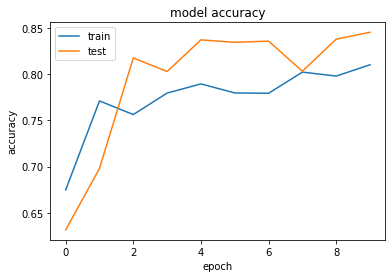

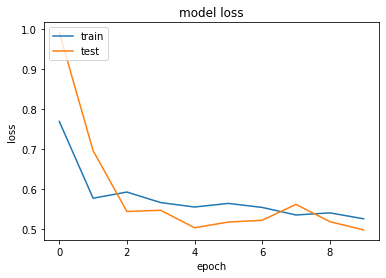

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.6593078374862671 , AUC = 0.7290586233139038 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8454552051083593
test 0.7289739963007289

-----------------------------------------------------------------


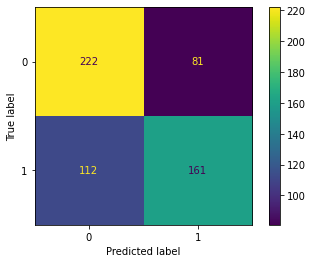

In [50]:
# Create directory to save models
import matplotlib.pyplot as plt

rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  optimizer = keras.optimizers.Adam(lr=0.01)

  MERGM.compile(
      optimizer = optimizer,
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  

  tfeatures = DATA_train[RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  val_features= DATA_val[RUN]['MFCCS'][:]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][:]
  val_labels  = DATA_val[RUN]['LABELS'][ :]


#  tfeatures = DATA_train[RUN]['MFCCS'][:]
#  textra    = DATA_train[RUN]['EXTRA'][:]
#  timgs     = DATA_train[RUN]['MEL'][:]
#  labels    = DATA_train[RUN]['LABELS'][:]
#
#  test_features= DATA_test[RUN]['MFCCS'][ : ]
#  test_extra   = DATA_test[RUN]['EXTRA'][ : ]
#  test_imgs    = DATA_test[RUN]['MEL'][ : ]
#  test_labels  = DATA_test[RUN]['LABELS'][ : ]
#                                        
#  val_features= DATA_val[RUN]['MFCCS'][  :]
#  val_extra   = DATA_val[RUN]['EXTRA'][:]
#  val_imgs    = DATA_val[RUN]['MEL'][  :]
#  val_labels  = DATA_val[RUN]['LABELS'][  :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=30,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

---
# 4-Model Visualization
---

0
Num_samples: 576
acc:  0.6649305555555556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


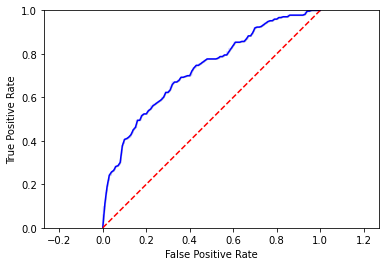

In [51]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/010--0.498--0.526.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)

  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
                                        
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(224,224))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()